In [167]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import sys

if int(sagemaker.__version__.split('.')[0]) != 2:
    !{sys.executable} -m pip install sagemaker --upgrade
    print("Installing previous SageMaker Version. Please restart the kernel")
else:
    print("Version is good")

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')

Version is good
Region = us-east-2


In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy as cp
import os
from time import sleep, gmtime, strftime
import json
import time
from datetime import datetime

In [311]:
pd.set_option('display.width', 1000)
plt.rcParams["figure.figsize"] = [16, 4]

In [169]:
!pip install sagemaker-experiments 
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [170]:
rawbucket= sess.default_bucket() # Alternatively you can use our custom bucket here. 

prefix = 'sagemaker-building-consumption-forecast' # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
testdatanolabelprefix = prefix + '/test_data_no_label'
trainheaderprefix = prefix + '/train_headers'

                                value
datetime                             
2020-12-11 05:00:02.207  1.397840e+02
2020-12-11 05:15:02.590  1.452751e+02
2020-12-11 05:30:02.347  1.446566e+02
2020-12-11 05:45:02.164  1.408305e+02
2020-12-11 06:00:02.250  1.405686e+02
...                               ...
2020-12-24 20:15:02.224  1.104764e-14
2020-12-24 20:30:02.128  9.295031e-16
2020-12-24 20:45:02.131  7.819170e-17
2020-12-24 21:00:02.133  6.554825e-18
2020-12-24 21:15:02.137  5.510756e-19

[1327 rows x 1 columns]


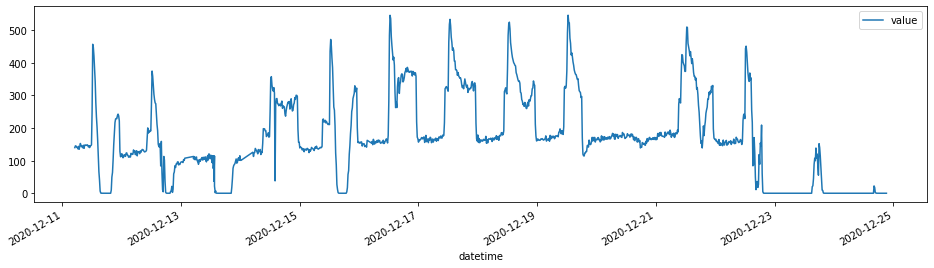

In [312]:
bdata = pd.read_csv('building_5_meter_data.csv')
bdata.index = pd.to_datetime(bdata['datetime'])
del bdata['datetime']
bdata = bdata[bdata.index > datetime(2020,11,10)]
# bdata.insert(0,'dry_temp_f',100*np.random.rand(len(bdata)))
print(bdata)
bdata.plot.line()

In [325]:
def splitData(X, split_fraction=0.7):
    split_index = int(len(X) * split_fraction)
    trainset = X.iloc[:split_index]
    testset = X.iloc[split_index:]
    return trainset,testset

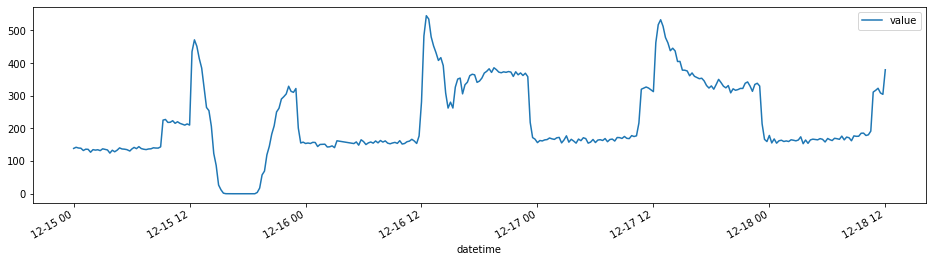

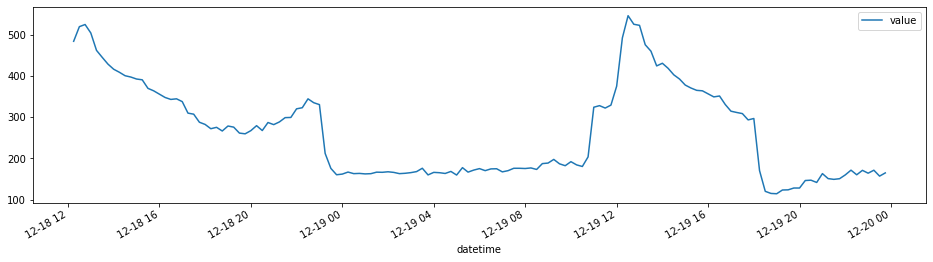

In [359]:
# Generate some baseline testing data
# We want to filter out some of the bad data from the beginning and end
# This clearly isn't enough data to do anything useful with, but its a start
bdata_2 = bdata["2020-12-15":"2020-12-19"]
trainset, testset = splitData(bdata_2)
trainset.plot.line()
testset.plot.line()

FIT RMSE = 30.36
Test RMSE = 24.56
Time to train = 0 seconds


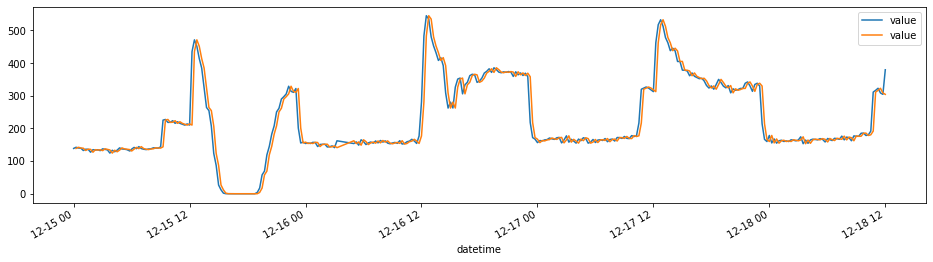

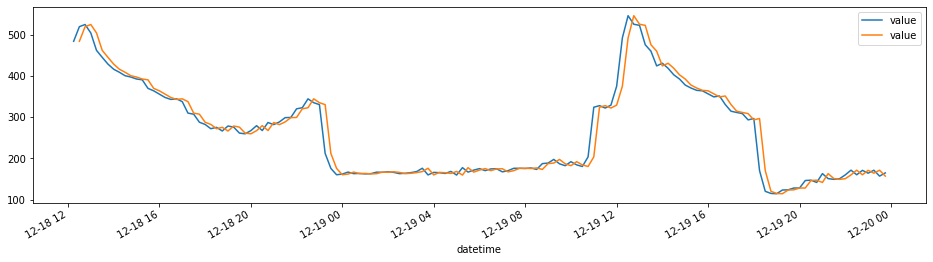

In [373]:
# Let's establish a baseline for training by doing a simple datashift,
# Where our prediction is simply the previous value
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_trainset['value'])
bl_y_pred = bl_y.shift(periods=1)
bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('FIT RMSE = %.2f' % bl_rmse)

bl_y_pred.plot(ax=bl_trainset.plot())

bl_y = pd.DataFrame(bl_testset['value'])
bl_y_pred = bl_y.shift(periods=1)
bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('Test RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')

bl_y_pred.plot(ax=bl_testset.plot())

In [284]:
"""
Creates windows from raw data matrix X, where columns of X are input variables
If there are more than one input variable, it is assumed the last column is the one to be predicted on
Variables that are not predicted (e.g. weather), are required to have prediction data included as variable columns
It is assumed that X is DateTime indexed, and that the rows are evenly temporally spaced
"""
def createWindows(X, window_size=4, response_size=1):
        x = cp.deepcopy(X)
        
        w = window_size
        r = response_size
        
        # Store original dimensions
        C = len(list(X))
        N = len(X)
        
        # Store end dimensions
        # Given N original datapoints, we can extract N - w - r + 1 windows
        l = N - w - r + 1
        # Given c columns, with w window size, we expect to have p = c * w predictors per window
        p = C * w
        
        # Create the names of the variables in the window
        names = []
        for j, col in enumerate(list(x)):        
            for i in range(w):
                names.append('{}_{}'.format(col, i+1))
        for i in range(r):
            names.append('Y_{}'.format(i+1))
                
        # Initialize our output dataframe
        df = pd.DataFrame(np.zeros(shape=(l, (p + r))), columns=names)

        # Populate by rows in the new dataframe
        for row_index in range(l):
            slices = np.array([])
            # Flatten the predictor columns
            for col_index in range(x.shape[1]):
                row = X.values[row_index:row_index + w, col_index]
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, row)) 
 
            # Flatten the response columns
            y = np.array(X.values[row_index + w: row_index + w + r, -1])
            slices = np.concatenate((slices, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[row_index,:] = slices

        df.index = X.index[w:l+w]
        return df


In [292]:
train_windows = createWindows(bdata, response_size=1)
print(bdata.head(10))
print(train_windows.head(5))

                            value
datetime                         
2020-12-11 05:00:02.207  139.7840
2020-12-11 05:15:02.590  145.2751
2020-12-11 05:30:02.347  144.6566
2020-12-11 05:45:02.164  140.8305
2020-12-11 06:00:02.250  140.5686
2020-12-11 06:15:02.113  136.1336
2020-12-11 06:30:02.364  143.6776
2020-12-11 06:45:02.144  134.6907
2020-12-11 07:00:02.212  142.7601
2020-12-11 07:15:02.132  152.4732
                          value_1   value_2   value_3   value_4       Y_1
datetime                                                                 
2020-12-11 06:00:02.250  139.7840  145.2751  144.6566  140.8305  140.5686
2020-12-11 06:15:02.113  145.2751  144.6566  140.8305  140.5686  136.1336
2020-12-11 06:30:02.364  144.6566  140.8305  140.5686  136.1336  143.6776
2020-12-11 06:45:02.144  140.8305  140.5686  136.1336  143.6776  134.6907
2020-12-11 07:00:02.212  140.5686  136.1336  143.6776  134.6907  142.7601


In [316]:
# Import some stuff specifically for our experimentation with ML
from sklearn.linear_model import LinearRegression

FIT RMSE = 18.06
test RMSE = 25.98
Time to train = 0.00 seconds


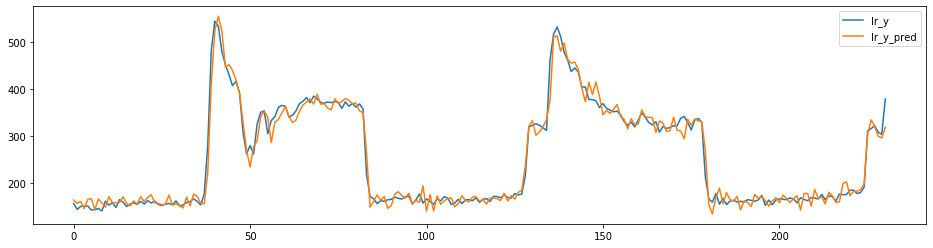

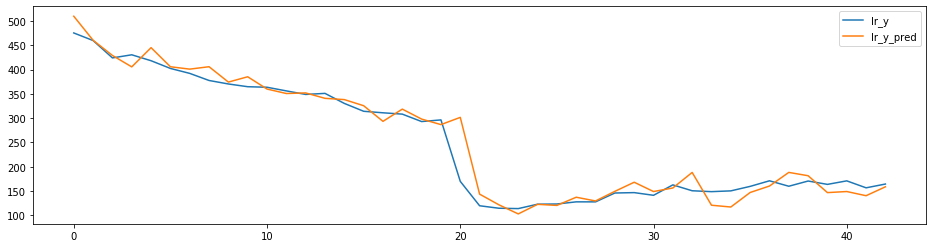

In [376]:
response_size = 1
window_size = 100
train_windows = createWindows(trainset, window_size=window_size, response_size=response_size)
test_windows = createWindows(testset, window_size=window_size, response_size=response_size)

lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-response_size], train_windows.iloc[:,-response_size])

t0 = time.time()
lr_train_y = train_windows['Y_1'].values
lr_test_y = test_windows['Y_1'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_test_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

lr_fit_residuals = lr_y_fit - lr_train_y
lr_fit_rmse = np.sqrt(np.sum(np.power(lr_fit_residuals,2)) / len(lr_fit_residuals))
print('FIT RMSE = %.2f' % lr_fit_rmse)
print('test RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

pd.DataFrame(data=np.transpose([lr_train_y, lr_y_fit]), columns=["lr_y","lr_y_pred"]).plot()
pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"]).plot()

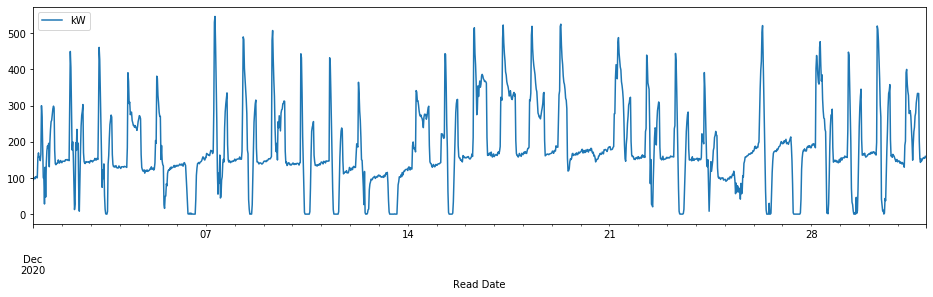

In [391]:
# We have new data to play with!
year_data = pd.read_csv('3000 Atrium Import.csv')
year_data.drop(year_data.columns.difference(['Read Date','kW']), 1, inplace=True)
# Reindex on Date
year_data.index = pd.to_datetime(year_data['Read Date'])
del year_data['Read Date']

year_data['2020-12'].plot()

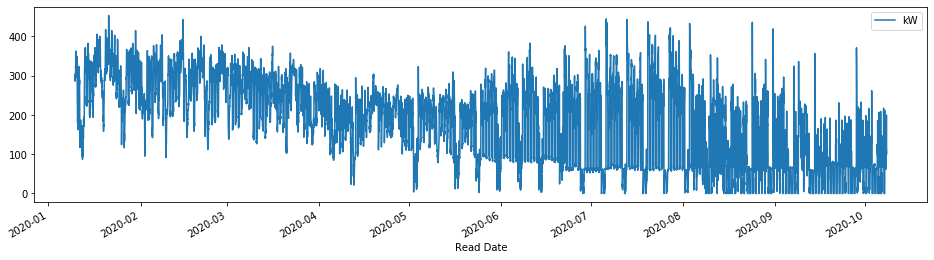

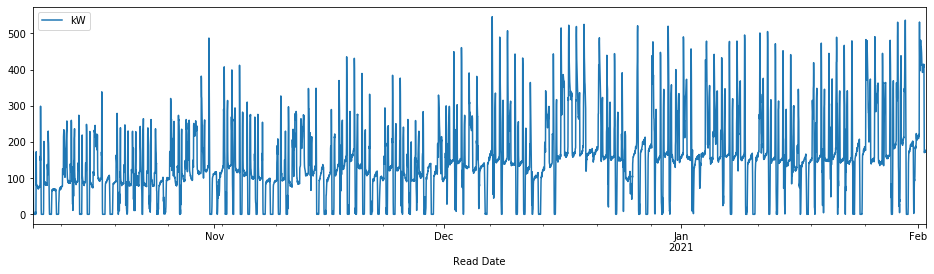

In [392]:
# Generate some testing data
trainset, testset = splitData(year_data)
trainset.plot.line()
testset.plot.line()

FIT RMSE = 29.17
Test RMSE = 42.23
Time to train = 0 seconds


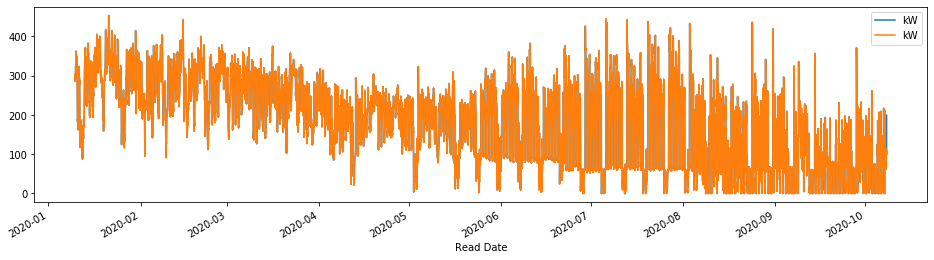

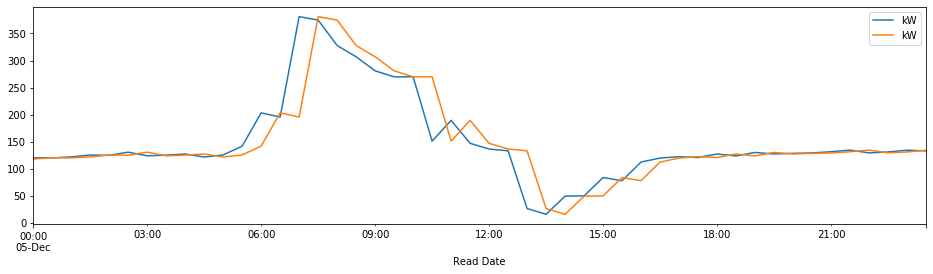

In [400]:
# As before, let's establish a baseline for training by doing a simple datashift,
# Where our prediction is simply the previous value
bl_trainset = cp.deepcopy(trainset)
bl_testset = cp.deepcopy(testset)

bl_y = pd.DataFrame(bl_trainset['kW'])
bl_y_pred = bl_y.shift(periods=1)
bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('FIT RMSE = %.2f' % bl_rmse)

bl_y_pred.plot(ax=bl_trainset.plot())

bl_y = pd.DataFrame(bl_testset['kW'])
bl_y_pred = bl_y.shift(periods=1)
bl_residuals = bl_y_pred - bl_y
bl_rmse = np.sqrt(np.sum(np.power(bl_residuals,2)) / len(bl_residuals))
print('Test RMSE = %.2f' % bl_rmse)
print('Time to train = 0 seconds')

bl_y_pred['2020-12-05'].plot(ax=bl_testset['2020-12-05'].plot())

In [404]:
response_size = 1
window_size = 1000
train_windows = createWindows(trainset, window_size=window_size, response_size=response_size)
test_windows = createWindows(testset, window_size=window_size, response_size=response_size)

lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-response_size], train_windows.iloc[:,-response_size])

t0 = time.time()
lr_train_y = train_windows['Y_1'].values
lr_test_y = test_windows['Y_1'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_test_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

lr_fit_residuals = lr_y_fit - lr_train_y
lr_fit_rmse = np.sqrt(np.sum(np.power(lr_fit_residuals,2)) / len(lr_fit_residuals))
print('FIT RMSE = %.2f' % lr_fit_rmse)
print('test RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))


FIT RMSE = 19.80
test RMSE = 30.69
Time to train = 0.04 seconds


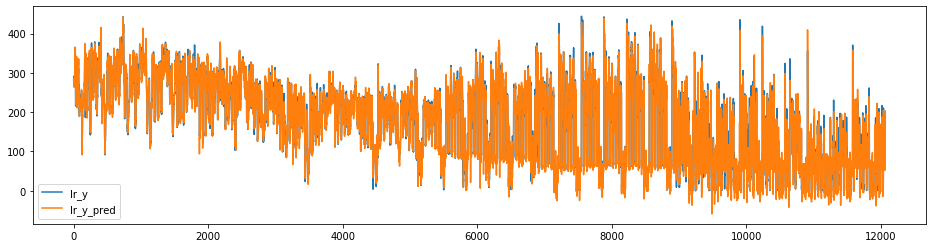

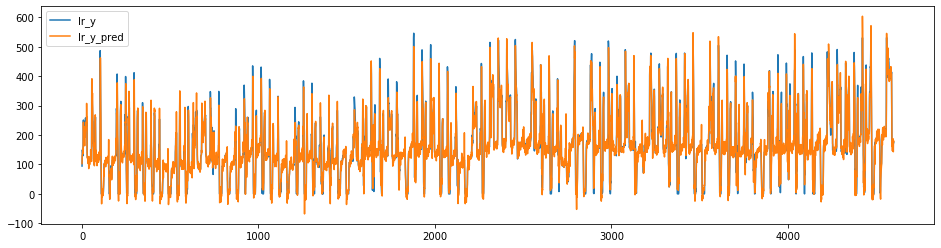

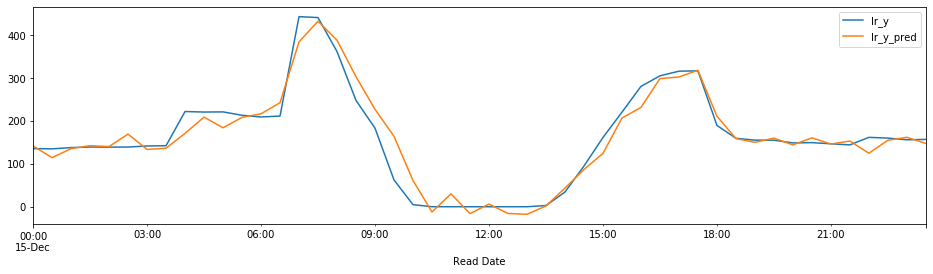

In [406]:
pd.DataFrame(data=np.transpose([lr_train_y, lr_y_fit]), columns=["lr_y","lr_y_pred"]).plot()
pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"]).plot()
pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"], index=test_windows.index)['2020-12-15'].plot()

In [412]:
def mape_vectorized_v2(a, b): 
    df = pd.DataFrame(data=np.transpose([a,b]), columns=['a','b'])
    df = df[df['a'] != 0]
    return (np.fabs(df['a'].values - df['b'].values)/df['a'].values).mean()

In [419]:
mape_vectorized_v2(lr_test_y + 1, lr_residuals + 1)

2.2944738352619303

In [455]:
# Alright, we have some baseline data here, let's go ahead and try to introduce weather data
# Read in data
wdata = pd.read_csv('2403314.csv')

# Drop unecessary columns
wdata.drop(wdata.columns.difference(['DATE','HourlyDryBulbTemperature','HourlyRelativeHumidity']), 1, inplace=True)
wdata.rename(columns={"HourlyDryBulbTemperature": "dry_temp_f", "HourlyRelativeHumidity": "humidity"}, errors="raise", inplace=True)

# Reindex on Date
wdata.index = pd.to_datetime(wdata['DATE'])
del wdata['DATE']

# Drop rows with non-numeric temps/humidities
wdata['dry_temp_f'] = pd.to_numeric(wdata['dry_temp_f'], errors='coerce')
wdata['humidity'] = pd.to_numeric(wdata['humidity'], errors='coerce')


# Resample to 15m 
print(wdata.head())

                     dry_temp_f  humidity
DATE                                     
2017-01-01 00:51:00        44.0      47.0
2017-01-01 01:51:00        44.0      49.0
2017-01-01 02:51:00        45.0      46.0
2017-01-01 03:51:00        44.0      47.0
2017-01-01 04:51:00        45.0      44.0


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30,31,33,41,42,43,48,49,51,53,58,59,69,71,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [457]:
# Reshape and interpolate the weather data
wdata = wdata[~wdata.index.duplicated()]
wdata = wdata.resample('1T').asfreq().interpolate(method='time').resample('15T').asfreq()
print(wdata.head())

                     dry_temp_f  humidity
DATE                                     
2017-01-01 00:45:00         NaN       NaN
2017-01-01 01:00:00        44.0      47.3
2017-01-01 01:15:00        44.0      47.8
2017-01-01 01:30:00        44.0      48.3
2017-01-01 01:45:00        44.0      48.8


In [459]:
# Reshape and interpolate the building data
year_data = pd.read_csv('3000 Atrium Import.csv')
year_data.drop(year_data.columns.difference(['Read Date','kW']), 1, inplace=True)
# Reindex on Date
year_data.index = pd.to_datetime(year_data['Read Date'])
del year_data['Read Date']

year_data = year_data[~year_data.index.duplicated()]
year_data = year_data.resample('1T').asfreq().interpolate(method='time').resample('15T').asfreq()

print(year_data.head())

                         kW
Read Date                  
2020-01-10 00:00:00  299.04
2020-01-10 00:15:00  301.14
2020-01-10 00:30:00  303.24
2020-01-10 00:45:00  299.94
2020-01-10 01:00:00  296.64


In [465]:
all_data = pd.merge(year_data, wdata, left_index=True, right_index=True)
all_data = all_data[['dry_temp_f', 'humidity', 'kW']]
print(all_data)

                     dry_temp_f  humidity      kW
2020-01-10 00:00:00       33.00     55.05  299.04
2020-01-10 00:15:00       33.00     56.80  301.14
2020-01-10 00:30:00       33.00     58.55  303.24
2020-01-10 00:45:00       33.00     60.30  299.94
2020-01-10 01:00:00       33.15     61.45  296.64
...                         ...       ...     ...
2020-12-31 14:45:00       43.15     60.45  275.04
2020-12-31 15:00:00       42.85     59.70  279.36
2020-12-31 15:15:00       42.60     59.20  293.40
2020-12-31 15:30:00       42.35     58.70  307.44
2020-12-31 15:45:00       42.10     58.20  314.46

[34240 rows x 3 columns]


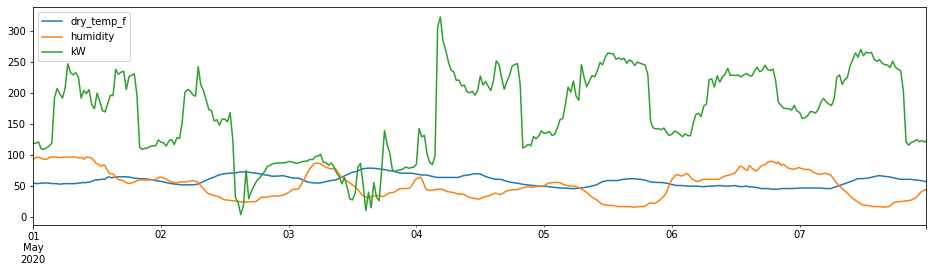

In [469]:
all_data['2020-05-01':'2020-05-07'].plot()

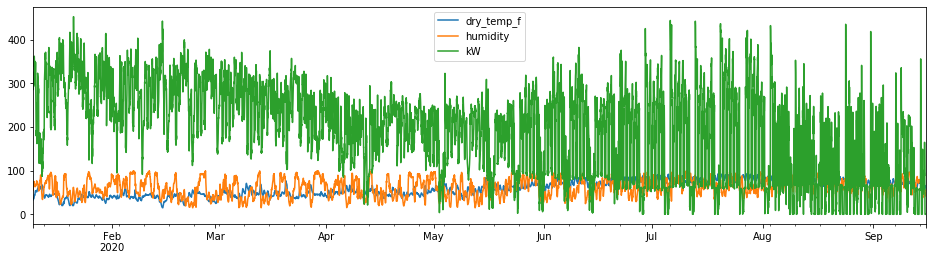

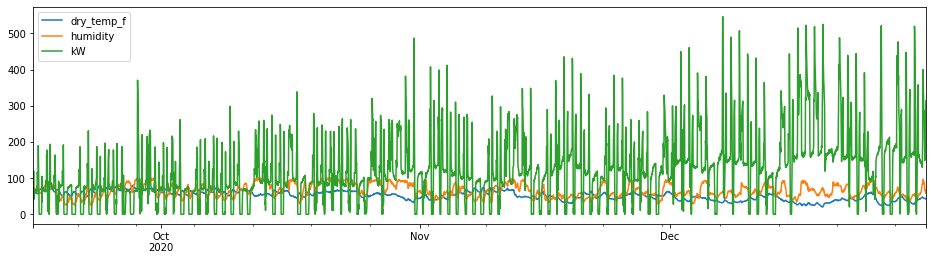

In [470]:
trainset, testset = splitData(all_data)
trainset.plot.line()
testset.plot.line()

In [471]:
response_size = 1
window_size = 1000
train_windows = createWindows(trainset, window_size=window_size, response_size=response_size)
test_windows = createWindows(testset, window_size=window_size, response_size=response_size)

lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-response_size], train_windows.iloc[:,-response_size])

t0 = time.time()
lr_train_y = train_windows['Y_1'].values
lr_test_y = test_windows['Y_1'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-1])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-1])
tF = time.time()

lr_residuals = lr_y_pred - lr_test_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

lr_fit_residuals = lr_y_fit - lr_train_y
lr_fit_rmse = np.sqrt(np.sum(np.power(lr_fit_residuals,2)) / len(lr_fit_residuals))
print('FIT RMSE = %.2f' % lr_fit_rmse)
print('test RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

FIT RMSE = 6.76
test RMSE = 10.50
Time to train = 0.19 seconds


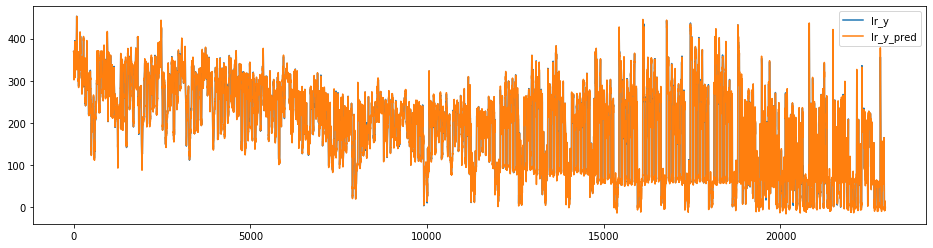

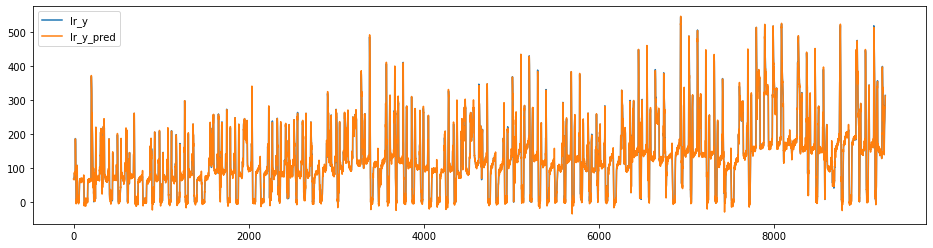

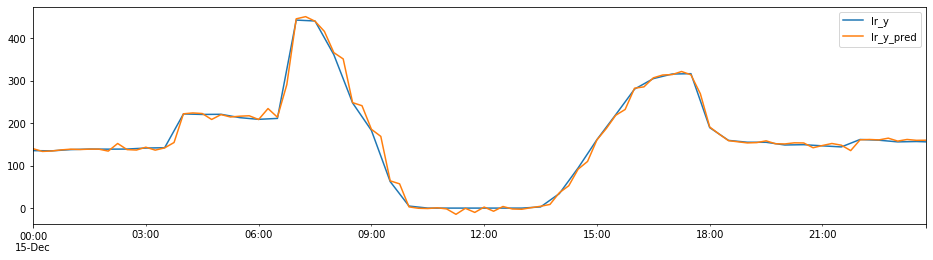

In [472]:
pd.DataFrame(data=np.transpose([lr_train_y, lr_y_fit]), columns=["lr_y","lr_y_pred"]).plot()
pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"]).plot()
pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"], index=test_windows.index)['2020-12-15'].plot()

In [473]:
mape_vectorized_v2(lr_test_y + 1, lr_residuals + 1)

1.3096107453324946

In [480]:
# Now that we have a working prediction setup, we need to start predicting more than just one period in advance
response_size = 96
window_size = 672
train_windows = createWindows(trainset, window_size=window_size, response_size=response_size)
test_windows = createWindows(testset, window_size=window_size, response_size=response_size)

lr_model = LinearRegression()
lr_model.fit(train_windows.iloc[:,:-response_size], train_windows.iloc[:,-response_size:])

t0 = time.time()
# lr_train_y = train_windows['Y_1'].values
# lr_test_y = test_windows['Y_1'].values
lr_y_fit = lr_model.predict(train_windows.iloc[:,:-response_size])
lr_y_pred = lr_model.predict(test_windows.iloc[:,:-response_size])
tF = time.time()

# lr_residuals = lr_y_pred - lr_test_y
# lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

# lr_fit_residuals = lr_y_fit - lr_train_y
# lr_fit_rmse = np.sqrt(np.sum(np.power(lr_fit_residuals,2)) / len(lr_fit_residuals))
# print('FIT RMSE = %.2f' % lr_fit_rmse)
# print('test RMSE = %.2f' % lr_rmse)
print('Time to train = %.2f seconds' % (tF - t0))

Time to train = 0.36 seconds


In [504]:
lr_train_y = train_windows.iloc[:,-response_size:]
lr_test_y = test_windows.iloc[:,-response_size:]

lr_residuals = lr_y_pred - lr_test_y
lr_rmse = np.sqrt(np.sum(np.sum(np.power(lr_residuals,2))) / len(lr_residuals * len(list(lr_residuals))))

lr_fit_residuals = lr_y_fit - lr_train_y
lr_fit_rmse = np.sqrt(np.sum(np.sum(np.power(lr_fit_residuals,2))) / (len(lr_fit_residuals) * len(list(lr_fit_residuals))))
print('FIT RMSE = %.2f' % lr_fit_rmse)
print('test RMSE = %.2f' % lr_rmse)

FIT RMSE = 44.73
test RMSE = 647.93


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


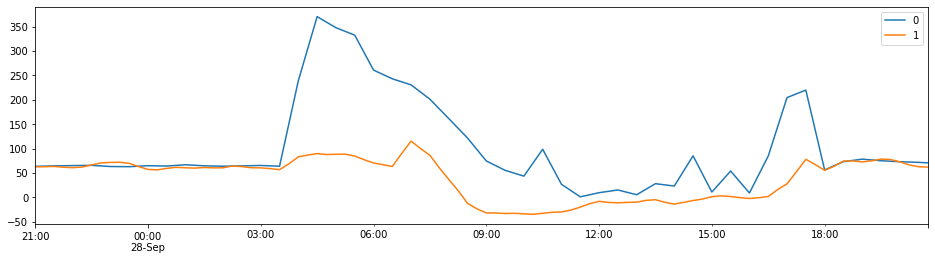

In [521]:
print(type(lr_train_y))
print(type(lr_y_fit))

offset = 500
data = np.array([lr_test_y.iloc[offset], np.transpose(lr_y_pred[offset])])
df = pd.DataFrame(np.transpose(data), index=test_windows.index[offset:offset+response_size])
df.plot()
# pd.DataFrame(data=np.transpose([lr_train_y, lr_y_fit]), columns=["lr_y","lr_y_pred"]).plot()
# pd.DataFrame(data=np.transpose([lr_test_y, lr_y_pred]), columns=["lr_y","lr_y_pred"]).plot()
# pd.DataFrame(data=np.transpose([lr_test_y.iloc[100], np.transpose(lr_y_pred[100])]), columns=["lr_y","lr_y_pred"], index=test_windows.index)['2020-12-15'].plot()

In [ ]:
# Clearly this is pretty bad.
# I suspsect the problem is that we aren't using weather forecasts at all,
# and our building predictions are assuming the weather will be relatively stable
#
# To fix this, we need to fix our windowing system to account for new weather data